In [33]:
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from tqdm import tnrange, tqdm_notebook, tqdm

# import skorch
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

import numpy as np
import matplotlib
# matplotlib.use('agg')
import matplotlib.pyplot as plt
from Lung_dataset import ILDDataset

In [7]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [23]:
NUM_TOTAL = 1982
NUM_TRAIN = 1500



#add path as absolute path for root dir

im_size = 128

lung_dataset_train = ILDDataset(csv_file='../Clean_train_test_dataset/Dataset/train_labels.csv',
                          root_dir='../Clean_train_test_dataset/Dataset/train',
                          mask=True, HU=True, train=True, resize=128)

#add path as absolute path for root dir
lung_dataset_test = ILDDataset(csv_file='../Clean_train_test_dataset/Dataset/test_labels.csv',
                          root_dir='../Clean_train_test_dataset/Dataset/test',
                          mask=True, HU=True, resize=128)

loader_train = DataLoader(lung_dataset_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = DataLoader(lung_dataset_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TOTAL)))

loader_test = DataLoader(lung_dataset_test, batch_size=32)


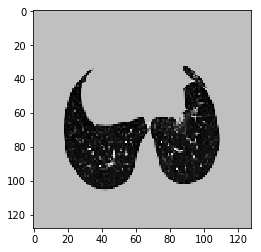

label: 2


In [24]:
#show datasample
sample = lung_dataset_train[12]
plt.imshow(sample[0], cmap='gray')
plt.show()
print("label: " + str(sample[1]))

In [25]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)


In [26]:
def get_model(freeze=False):
    """
    Used to fetch model for classification
    """
    
    num_classes = 3
    """
    
    model = models.resnet50(pretrained=True)
    model.avgpool = nn.AvgPool2d(1, stride=1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=1, bias=False)
    if(freeze==True):
        for param in model.parameters():
            param.requires_grad = False
    model.fc = nn.Linear(32768, num_classes)
    """
    
    
    channel_1 = 128
    channel_2 = 64
    channel_3 = 64
    channel_4 = 32

    model = nn.Sequential(
        nn.Conv2d(1, channel_1, kernel_size=3, padding=2),
        nn.BatchNorm2d(channel_1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d(p=0.5),
        nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=2),
        nn.BatchNorm2d(channel_2),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(channel_2, channel_3, kernel_size=3, padding=2),
        nn.BatchNorm2d(channel_3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(channel_3, channel_4, kernel_size=3, padding=2),
        nn.BatchNorm2d(channel_4),
        nn.ReLU(),
        nn.MaxPool2d(2),
        Flatten(),
        nn.Linear(2592, 3)
    )
    
    return model
    

In [27]:
def check_accuracy(loader, model, train=False, val = False):
    predictedStore = []
    solutionStore = []
    if loader.dataset.train and train == True:
        print('Checking accuracy on training set')
    elif val:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            x.unsqueeze_(1)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            predictedStore.append(preds.view(-1,).cpu().numpy().tolist())
            solutionStore.append(y.data.view(-1,).cpu().numpy().tolist())
            
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples      
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        
    return acc,predictedStore,solutionStore
 

In [28]:
def train(model, optimizer, epochs=1, overfit=False):
    """
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    best_acc = 0;
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            
            #38,16,46
#             weights = torch.tensor([33/49, 49/18, 1], device= device, dtype=dtype)
            weights = torch.tensor([1,1, 1], device= device, dtype=dtype)
            x.unsqueeze_(1)
            scores = model(x)
            Loss = nn.CrossEntropyLoss(weight = weights)
            loss = Loss(scores, y)
            
            
            reg = torch.tensor(0.0001, device= device, dtype=dtype)
            l2_reg = torch.tensor(0. , device= device, dtype=dtype)
            for param in model.parameters():
                l2_reg += torch.norm(param)
            loss += reg * l2_reg

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
        print('Epoch %d, loss = %.4f' % (e, loss.item()))
        if(overfit):
            _,predictedStoreTrain,solutionStoreTrain = check_accuracy(loader_train, model, train=True)
        acc,predictedStoreVal,solutionStoreVal = check_accuracy(loader_val, model, val = True)
        if acc > best_acc:
            best_acc = acc
            best_model = model
            predStoreTrain = predictedStoreTrain
            solStoreTrain = solutionStoreTrain
            predStoreVal = predictedStoreVal
            solStoreVal = solutionStoreVal
        print()
    return best_model,predStoreTrain,solStoreTrain,predStoreVal,solStoreVal

In [29]:
model1 = get_model()
optimizer = optim.Adam(model1.parameters(), lr = 0.0001, weight_decay= 1e-5)
best_model,predStoreTrain,solStoreTrain,predStoreVal,solStoreVal = train(model1, optimizer, epochs= 15, overfit=True)

Epoch 0, loss = 0.8255
Checking accuracy on training set
Got 843 / 1500 correct (56.20)
Checking accuracy on validation set
Got 188 / 482 correct (39.00)

Epoch 1, loss = 0.9357
Checking accuracy on training set
Got 870 / 1500 correct (58.00)
Checking accuracy on validation set
Got 170 / 482 correct (35.27)

Epoch 2, loss = 0.7617
Checking accuracy on training set
Got 932 / 1500 correct (62.13)
Checking accuracy on validation set
Got 186 / 482 correct (38.59)

Epoch 3, loss = 0.6989
Checking accuracy on training set
Got 853 / 1500 correct (56.87)
Checking accuracy on validation set
Got 140 / 482 correct (29.05)

Epoch 4, loss = 0.9658
Checking accuracy on training set
Got 1006 / 1500 correct (67.07)
Checking accuracy on validation set
Got 193 / 482 correct (40.04)

Epoch 5, loss = 0.7765
Checking accuracy on training set
Got 982 / 1500 correct (65.47)
Checking accuracy on validation set
Got 150 / 482 correct (31.12)

Epoch 6, loss = 0.7528
Checking accuracy on training set
Got 1024 / 1

In [21]:
#Check Test set
acc,predStoreTest,solStoreTest = check_accuracy(loader_test, best_model)

Checking accuracy on test set


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [35]:
def jitter(X, ox, oy): #from cs231n
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

In [45]:
def create_class_visualization(target_y, model, dtype, **kwargs): #from cs231n
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and make it requires gradient.
    img = torch.randn(1, 1, 128, 128).mul_(1.0).requires_grad_()

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))

        ########################################################################
        # TODO: Use the model to compute the gradient of the score for the     #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. Don't forget the #
        # L2 regularization term!                                              #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        scores = model(img.cpu())
        loss = scores[0, target_y] - l2_reg*torch.sum(img.data**2)
        loss.backward()
        img.data += learning_rate*img.grad
        img.grad.zero_()
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        
        # Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.data.clone().cpu()))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.data.cpu())

In [46]:
out = create_class_visualization(0, best_model, dtype)

RuntimeError: Expected object of type torch.FloatTensor but found type torch.cuda.FloatTensor for argument #2 'weight'

Confusion matrix, without normalization
[[598   0 109]
 [ 56  26  50]
 [130   0 531]]
Confusion matrix, without normalization
[[ 72   0  27]
 [ 33   0  68]
 [158   0 124]]
Normalized confusion matrix
[[0.73 0.   0.27]
 [0.33 0.   0.67]
 [0.56 0.   0.44]]


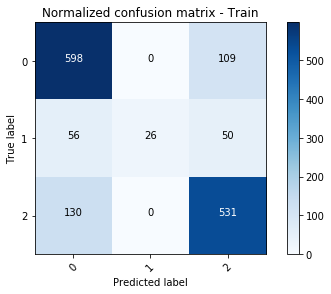

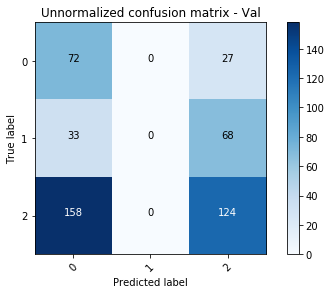

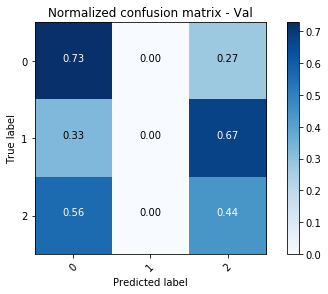

In [42]:
import itertools
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
    
##Actual Plots

y_pred_train = np.concatenate([np.array(i) for i in predStoreTrain])
y_train = np.concatenate([np.array(i) for i in solStoreTrain])

y_pred_val = np.concatenate([np.array(i) for i in predStoreVal]) 
y_val = np.concatenate([np.array(i) for i in solStoreVal])

# y_pred_test = np.concatenate([np.array(i) for i in predStoreTest]) 
# y_test = np.concatenate([np.array(i) for i in solStoreTest])

cnf_matrix1 = confusion_matrix(y_train, y_pred_train)
cnf_matrix2 = confusion_matrix( y_val, y_pred_val)
# cnf_matrix3 = confusion_matrix(y_test, y_pred_test)



class_names = [0,1,2]
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=class_names,
                      title='Normalized confusion matrix - Train')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=class_names,
                      title='Unnormalized confusion matrix - Val')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=class_names, normalize=True,
                      title='Normalized confusion matrix - Val')

plt.show()


#### 